In [1]:
import pandas as pd
import numpy as np
import glob
import os
import re
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data_path = "/Users/kritiaxh/Documents/PoldrackLab/SharedControl/data/raw/"
exp_stage = "final/"
task = "simple_stop"

pattern = os.path.join(data_path, exp_stage, '*', task, '*.csv')

data_files = glob.glob(pattern)

In [4]:
def get_subject_label(file):
    
    match = re.search(r'/sub-(s\d{3})/', file)
    
    if match:
        subject_label = match.group(1)
        print("Subject label:", subject_label)
        return subject_label
    else:
        print("No subject label found.")
        return None

In [5]:
def compute_SSRT(df, max_go_rt = 2, violation_flag = False):

    avg_SSD = None
    
    df = df.query('Phase == "test"')
    
    go_trials = df.loc[df.trialType == 'go']
    stop_df = df.loc[df.trialType == 'stop']

    # Filter stop trials for SSDs less than 200ms if violation_flag is activated
    # if violation_flag:
    #     stop_df = stop_df[stop_df['ssd'] < 0.2]

    go_replacement_df = go_trials.where(~go_trials['rt'].isna(), max_go_rt)
    sorted_go = go_replacement_df.rt.sort_values(ascending = True, ignore_index=True)
    stop_failure = stop_df.loc[stop_df['rt'].notna()]
    if len(stop_df) > 0:
        p_respond = len(stop_failure)/len(stop_df)
        avg_SSD = stop_df.ssd.mean()
    # else:
    #     p_respond = 1

    nth_index = int(np.rint(p_respond*len(sorted_go))) - 1

    if nth_index < 0:
        nth_RT = sorted_go[0]
    elif nth_index >= len(sorted_go):
        nth_RT = sorted_go[-1]
    else:
        nth_RT = sorted_go[nth_index]
    
    if avg_SSD:
        SSRT = nth_RT - avg_SSD
    else:
        SSRT = None

    return SSRT

In [6]:
def preprocess_stop_data(df):
    df = df.query(f'Phase == "test"')
    df = df[['Block', 'Phase', 'trialType', 'goStim', 'correctResponse', 'ssd', 'goResp_test.keys', 'goResp_test.corr','goResp_test.rt']]
    
    df.loc[:, 'stop_acc'] = np.where(df['trialType'] == 'stop', 
                                 np.where(df['goResp_test.keys'].isnull(), 1, 0),  
                                 np.nan)

    df.loc[:, 'go_acc'] = np.where(df['trialType'] == 'go', 
                                   np.where(df['goResp_test.keys'] == df['correctResponse'], 1, 0), 
                                   np.nan)

    df.loc[:, 'stop_failure_acc'] = np.where(
        (df['trialType'] == 'stop') & (df['goResp_test.rt'].notna()),
        np.where(df['goResp_test.keys'] == df['correctResponse'], 1, 0),
        np.nan)
    
    df.rename(columns={'goResp_test.keys': 'response', 'goResp_test.corr': 'correct', 'goResp_test.rt': 'rt'}, inplace=True)
    
    return df

In [7]:
def analyze_violations(df):
    violations_data = []

    for i in range(len(df) - 1):  # Go until the second to last trial
        # Check for a Go trial followed by a Stop trial with a violation
        if (df.iloc[i]['trialType'] == 'go' and
            df.iloc[i + 1]['trialType'] == 'stop' and
            pd.notna(df.iloc[i + 1]['rt'])):
            
            go_rt = df.iloc[i]['rt']         # RT of Go trial
            stop_rt = df.iloc[i + 1]['rt']  # RT of Stop trial
            
            if pd.notna(go_rt) and pd.notna(stop_rt):  # Ensure RTs are valid
                difference = stop_rt - go_rt  # Calculate the difference
                ssd = df.iloc[i + 1]['ssd']    # SSD for the Stop trial
                violations_data.append({'difference': difference, 'ssd': ssd})

    return pd.DataFrame(violations_data)

In [12]:
task_metrics = {}
all_violations_df = pd.DataFrame()
for file in data_files:
    subject_label = get_subject_label(file)
    
    df = pd.read_csv(file)

    if subject_label == 's019':
        df = df[df["stopBlocks.thisN"] != 2]

    # Preprocess data
    df = preprocess_stop_data(df)
    
    # Analyze violations and aggregate results
    violations_df = analyze_violations(df)
    all_violations_df = pd.concat([all_violations_df, violations_df], ignore_index=True)

    final_aggregated_results = all_violations_df.groupby('ssd').agg(
        violations_count=('difference', 'count'),
        avg_difference=('difference', 'mean')
    ).reset_index()

    # Calculate other task metrics
    go_rt = df.query("trialType == 'go'").rt.mean()
    stop_fail_rt = df.query("trialType == 'stop'").rt.mean()
    go_acc = df.query("trialType == 'go'").go_acc.mean()
    stop_failure_acc = df.query("trialType == 'stop'").stop_failure_acc.mean()
    stop_success = df.query("trialType == 'stop'").stop_acc.mean()
    avg_ssd = df.query("trialType == 'stop'").ssd.mean()
    min_ssd = df.query("trialType == 'stop'").ssd.min()
    max_ssd = df.query("trialType == 'stop'").ssd.max()
    min_ssd_count = (df.query("trialType == 'stop'").ssd == 0).sum()
    max_ssd_count = (df.query("trialType == 'stop'").ssd == 0.75).sum()
    ssrt = compute_SSRT(df)
    # ssrt_with_violations = compute_SSRT(df, violation_flag=True)

    
    task_metrics[subject_label] = {
        'go_rt': go_rt,
        'stop_fail_rt': stop_fail_rt,
        'go_acc': go_acc,
        'stop_failure_acc': stop_failure_acc,
        'stop_success': stop_success,
        'avg_ssd': avg_ssd,
        'min_ssd': min_ssd,
        'max_ssd': max_ssd,
        'min_ssd_count': min_ssd_count,
        'max_ssd_count': max_ssd_count,
        'ssrt': ssrt,
        # 'ssrt_with_violations': ssrt_with_violations,
    }

Subject label: s042
Subject label: s029
Subject label: s016
Subject label: s011
Subject label: s018
Subject label: s027
Subject label: s020
Subject label: s043
Subject label: s021
Subject label: s019
Subject label: s026
Subject label: s010
Subject label: s028
Subject label: s017
Subject label: s035
Subject label: s032
Subject label: s004
Subject label: s005
Subject label: s033
Subject label: s034
Subject label: s012
Subject label: s015
Subject label: s023
Subject label: s024
Subject label: s041
Subject label: s025
Subject label: s022
Subject label: s014
Subject label: s013
Subject label: s040
Subject label: s031
Subject label: s036
Subject label: s009
Subject label: s007
Subject label: s038
Subject label: s006
Subject label: s039
Subject label: s037
Subject label: s008
Subject label: s030


In [13]:
metrics = pd.DataFrame(task_metrics).T
metrics = metrics.sort_index()

In [14]:
metrics.to_csv('output/simple_stop_metrics.csv')

In [15]:
metrics

,go_rt,stop_fail_rt,go_acc,stop_failure_acc,stop_success,avg_ssd,min_ssd,max_ssd,min_ssd_count,max_ssd_count,ssrt
s004,0.506527,0.441187,1.000000,1.000000,0.458333,0.293750,0.10,0.50,0.0,0.0,0.206134
s005,0.509649,0.420273,0.989583,1.000000,0.520833,0.320833,0.15,0.55,0.0,0.0,0.160407
s006,0.509721,0.456682,0.979167,1.000000,0.520833,0.308333,0.10,0.50,0.0,0.0,0.176054
s007,0.768507,0.661880,0.989583,1.000000,0.541667,0.531250,0.25,0.75,0.0,1.0,0.203817
s008,0.568068,0.487529,0.958333,0.913043,0.520833,0.372917,0.20,0.55,0.0,0.0,0.183402
s009,0.612782,0.464986,1.000000,1.000000,0.562500,0.377083,0.25,0.55,0.0,0.0,0.222842
s010,0.510829,0.475526,1.000000,1.000000,0.520833,0.339583,0.25,0.45,0.0,0.0,0.169163
s011,0.467518,0.423023,1.000000,1.000000,0.520833,0.285417,0.20,0.40,0.0,0.0,0.186240
s012,0.688924,0.566016,1.000000,1.000000,0.541667,0.475000,0.30,0.70,0.0,0.0,0.197466
s013,0.774861,0.611381,0.979167,1.000000,0.562500,0.479167,0.30,0.75,0.0,1.0,0.278431


In [45]:
np.mean(metrics['ssrt'])

0.2148430297275384

In [46]:
final_aggregated_results.to_csv('output/simple_stop_violations_aggregated_results.csv')

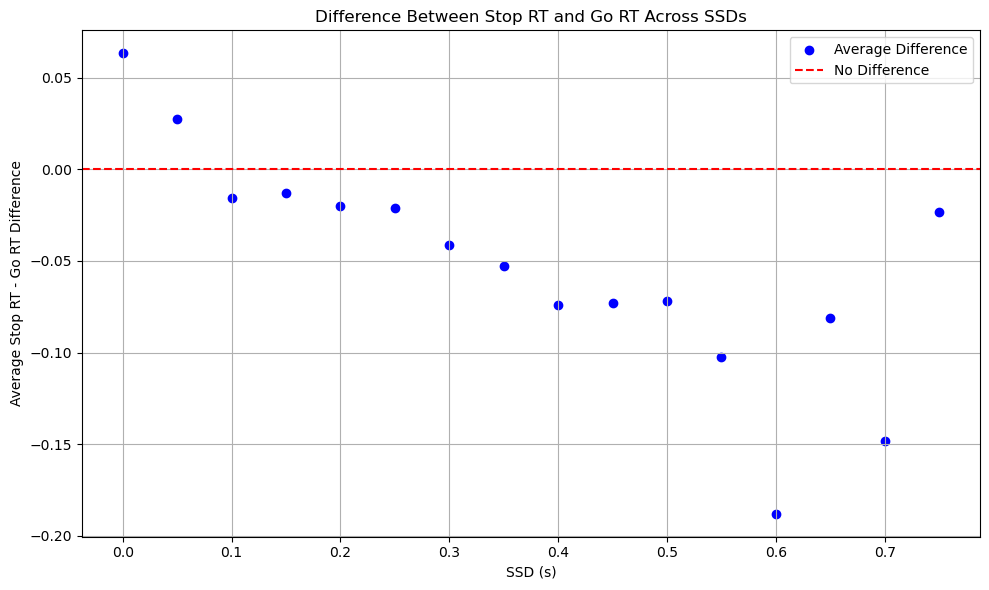

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(final_aggregated_results['ssd'], final_aggregated_results['avg_difference'], color='blue', label='Average Difference')
plt.xlabel('SSD (s)')
plt.ylabel('Average Stop RT - Go RT Difference')
plt.title('Difference Between Stop RT and Go RT Across SSDs')
plt.axhline(0, color='red', linestyle='--', label='No Difference')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('figures/violations_with_ssd.png')
plt.show()

In [48]:
# Perform binomial test checking if proportion of stop successes are around 0.5
stop_success_count = int(sum(metrics['stop_success'] * 200))
p_value = stats.binomtest(stop_success_count, n = 200 * 40, p = 0.5, alternative='two-sided')
print(p_value)


BinomTestResult(k=4116, n=8000, alternative='two-sided', statistic=0.5145, pvalue=0.009799896405706068)


In [49]:
import subprocess
import re

# Run pip freeze and capture output
result = subprocess.run(['pip', 'freeze'], capture_output=True, text=True)

# Use a regex to remove lines that include 'file:///'
cleaned_output = re.sub(r' @ file://[^\n]+', '', result.stdout)

# Write the cleaned output to a new requirements.txt file
with open('requirements.txt', 'w') as f:
    f.write(cleaned_output)

print("Cleaned requirements.txt has been generated.")


Cleaned requirements.txt has been generated.
